# Random Forrest Classification

In [2]:
import time

import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterSampler, ParameterGrid, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from Transformer import ReplaceZeroWithMean

DATAPATH = "../Data"
MODELPATH = "../Data/Models/RFC"

data = pd.read_csv(f"{DATAPATH}/diabetes.csv")
X = data.drop("Outcome", axis=1)
y = data["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1)
imputer = ReplaceZeroWithMean(["Glucose", "BloodPressure", "SkinThickness", "BMI"])
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

## WITHOUT Hyperparameter Tuning

In [3]:
rfc_base = RandomForestClassifier(n_jobs=-1, random_state=1)
rfc_base.fit(X_train, y_train)

joblib.dump(rfc_base, f"{MODELPATH}/RFC_no_hyper.pkl")

['../Data/Models/RFC/RFC_no_hyper.pkl']

## WITH Hyperparameter Tuning

In [4]:
# np.logspace(-2, 2, 50),
# np.linspace(50, 1000, 10),
from pprint import pprint
import sys
from joblib import Parallel, delayed


param_dist = {  # TODO: 0.857
    "n_estimators": list(range(50, 150, 10)),
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": np.linspace(2, 50, 2, dtype=np.int8),
    "max_features": ["sqrt", "log2"],
    "max_leaf_nodes": [None, 5, 8, 9, 10, 11, 12, 13, 14, 15, 20, 50, 100],
    "class_weight": [None, "balanced", "balanced_subsample"],
}

# param_dist = {  # TODO: 0.837
#     "n_estimators": list(range(50, 500, 50)),  # Number of trees in the forest
#     "criterion": ["gini", "entropy", "log_loss"],  # Splitting criteria
#     "max_depth": [None] + list(range(10, 110, 10)),  # Maximum depth of the trees
#     "min_samples_split": list(range(2, 21, 2)),  # Minimum samples required to split a node
#     "min_samples_leaf": list(range(1, 21, 2)),  # Minimum samples required to form a leaf
#     "min_weight_fraction_leaf": np.linspace(0.0, 0.5, 6),  # Minimum weighted fraction of the sum of weights at a leaf
#     "max_features": ["sqrt", "log2", None, 0.5, 0.75],  # Number of features to consider for the best split
#     "max_leaf_nodes": [None] + list(range(10, 200, 20)),  # Maximum number of leaf nodes
#     "bootstrap": [True],  # Whether to use bootstrap samples
#     "class_weight": [None, "balanced", "balanced_subsample"],  # Weights associated with classes
#     "ccp_alpha": np.linspace(0.0, 0.1, 5),  # Complexity parameter for pruning
#     "max_samples": [None] + list(np.linspace(0.5, 1.0, 6)),  # Fraction of samples to draw when bootstrap is True
# }

param_sampler = list(ParameterSampler(param_dist, n_iter=10000, random_state=1))


def train_and_evaluate(params):
    model = RandomForestClassifier(n_jobs=-1, random_state=1, **params)
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return test_score, model


results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(params) for params in param_sampler)

rfc_hpt_score, rfc_hpt = max(results, key=lambda x: x[0])
print(rfc_hpt_score)

joblib.dump(rfc_hpt, f"{MODELPATH}/RFC_hyper.pkl")

/Users/niklas/Uni/semester3/machineLearing/vortrag/.venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4680 is smaller than n_iter=10000. Running 4680 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.8571428571428571


['../Data/Models/RFC/RFC_hyper.pkl']

## WITH Hyperparamerter Tuning AND Cross Validation

In [5]:
param_dist = {  # 0.831
    "n_estimators": list(range(50, 150, 15)),
    "criterion": ["gini", "log_loss"],
    "max_depth": np.linspace(2, 50, 3, dtype=np.int8),
    "max_features": ["sqrt", "log2"],
    "max_leaf_nodes": [None, 5, 8, 9, 10, 11, 12, 20, 50, 100],
    "class_weight": [None, "balanced", "balanced_subsample"],
}


rfc = RandomForestClassifier(n_jobs=-1, random_state=1)
models = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=5000, cv=6, n_jobs=-1)
models.fit(X_train, y_train)

rfc_hpt_cv = models.best_estimator_
print(rfc_hpt_cv.score(X_test, y_test))

joblib.dump(rfc_hpt_cv, f"{MODELPATH}/RFC_hyper_cv.pkl")

/Users/niklas/Uni/semester3/machineLearing/vortrag/.venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2520 is smaller than n_iter=5000. Running 2520 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.7857142857142857


['../Data/Models/RFC/RFC_hyper_cv.pkl']

## WITH Hyperparamerter Tuning AND Cross Validation (Stratisfied)

In [6]:
from sklearn.model_selection import StratifiedKFold


param_dist = {  # 0.831
    "n_estimators": list(range(50, 150, 15)),
    "criterion": ["gini", "log_loss"],
    "max_depth": np.linspace(2, 50, 3, dtype=np.int8),
    "max_features": ["sqrt", "log2"],
    "max_leaf_nodes": [None, 5, 8, 9, 10, 11, 12, 20, 50, 100],
    "class_weight": [None, "balanced", "balanced_subsample"],
}


rfc = RandomForestClassifier(n_jobs=-1, random_state=1)
cv_split = StratifiedKFold(n_splits=5, shuffle=True)
models = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=5000, cv=cv_split, n_jobs=-1)
models.fit(X_train, y_train)

rfc_hpt_cv = models.best_estimator_
print(rfc_hpt_cv.score(X_test, y_test))

joblib.dump(rfc_hpt_cv, f"{MODELPATH}/RFC_hyper_cv.pkl")

/Users/niklas/Uni/semester3/machineLearing/vortrag/.venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2520 is smaller than n_iter=5000. Running 2520 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.7857142857142857


['../Data/Models/RFC/RFC_hyper_cv.pkl']

## Further Parameter Adjustments

In [7]:
from pprint import pprint

rfc = RandomForestClassifier(max_features="log2", class_weight="balanced", n_jobs=-1, random_state=1)
param_grid = {
    "n_estimators": 125,
    "max_leaf_nodes": 20,
    "max_depth": 26,
}
for param, value in param_grid.items():
    percent = 5
    param_grid.update(
        {
            param: [int(value * i / 100) for i in range(105, 130, percent)]
            + [value]
            + [int(value * i / 100) for i in range(95, 70, -percent)]
        }
    )
pprint(param_grid)  # TODO: 0.837

models = GridSearchCV(rfc, param_grid, cv=10, n_jobs=-1)
models.fit(X_train, y_train)

rfc_best = models.best_estimator_
print(rfc_best.score(X_test, y_test))

joblib.dump(rfc_best, f"{MODELPATH}/RFC_hyper_cv_tuned.pkl")

{'max_depth': [27, 28, 29, 31, 32, 26, 24, 23, 22, 20, 19],
 'max_leaf_nodes': [21, 22, 23, 24, 25, 20, 19, 18, 17, 16, 15],
 'n_estimators': [131, 137, 143, 150, 156, 125, 118, 112, 106, 100, 93]}
0.8376623376623377


['../Data/Models/RFC/RFC_hyper_cv_tuned.pkl']

In [9]:
print(f"Base      : {rfc_base.score(X_test, y_test)}")
print(f"HPT       : {rfc_hpt_score}")
print(f"HPT+CV    : {rfc_hpt_cv.score(X_test, y_test)}")
print(f"HPT+CV+Opt: {rfc_best.score(X_test, y_test)}")

Base      : 0.8051948051948052
HPT       : 0.8571428571428571
HPT+CV    : 0.7857142857142857
HPT+CV+Opt: 0.8376623376623377


In [4]:
from pprint import pprint

RFC_URL = "../Data/Models/RFC"
SVM_URL = "../Data/Models/SVM"

models = {
    "RFC": f"{RFC_URL}/RFC_no_hyper.pkl",
    "RFC_hyper": f"{RFC_URL}/RFC_hyper.pkl",
    "RFC_hyper_cv": f"{RFC_URL}/RFC_hyper_cv.pkl",
    "RFC_hyper_cv_tuned": f"{RFC_URL}/RFC_hyper_cv_tuned.pkl",
    # "SVM": f"{SVM_URL}/SVM_no_hyper.pkl",
    # "SVM_para_grid": f"{SVM_URL}/SVM_para_grid.pkl",
    # "SVM_para_sampl": f"{SVM_URL}/SVM_para_sample.pkl",
}

scores = {}
for name, model in models.items():
    model = joblib.load(model)
    model.fit(X_train, y_train)
    scores.update({name: model.score(X_test, y_test)})

pprint(scores)

{'RFC': 0.8051948051948052,
 'RFC_hyper': 0.8571428571428571,
 'RFC_hyper_cv': 0.7857142857142857,
 'RFC_hyper_cv_tuned': 0.8376623376623377}


In [63]:
from dtreeviz import model


def render_tree_image(model_url, output_url):
    rfc = joblib.load(model_url)
    tree = rfc.estimators_[0]

    viz_model = model(
        tree,
        X_train=X_train,
        y_train=y_train,
        feature_names=X_train.columns,
        target_name="Diabetes",
        class_names=["No", "Yes"],
        tree_index=0,
    )

    tree_url = viz_model.view().save_svg()

    with open(tree_url, "rb") as tmp:
        with open(output_url, "wb") as svg:
            svg.write(tmp.read())


render_tree_image(models["RFC"], "../Data/RFC.svg")
render_tree_image(models["RFC_hyper"], "../Data/RFC_hyper.svg")
render_tree_image(models["RFC_hyper_cv"], "../Data/RFC_hyper_cv.svg")
render_tree_image(models["RFC_hyper_cv_tuned"], "../Data/RFC_hyper_cv_tuned.svg")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x

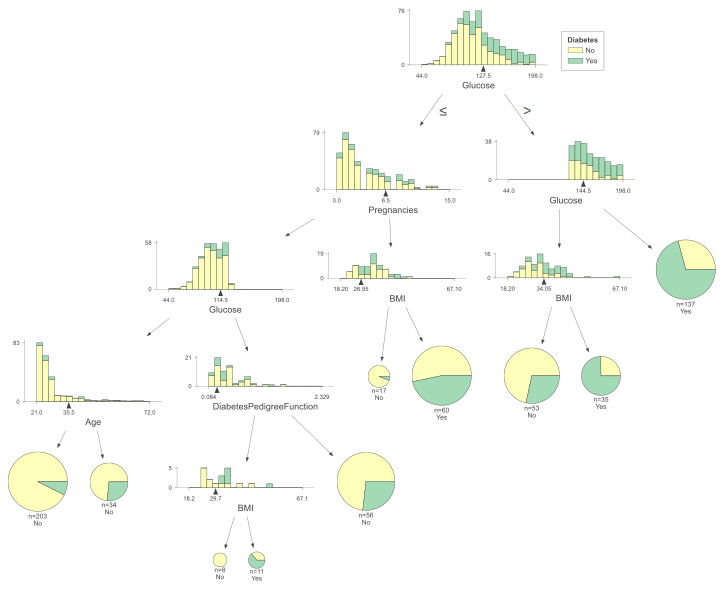

In [ ]:
from IPython.display import SVG

SVG(filename="../Data/RFC.svg")